In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt


In [2]:
image = cv2.imread("Images/table17verticalCropped.jpg")
image = cv2.resize(image, (0, 0), fx = 0.5, fy = 0.5)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) 
imgCanny = cv2.Canny(gray,150,50)
blur = cv2.GaussianBlur(gray, (7, 7), 1)
imgCannyBlur = cv2.Canny(blur,150,50)


In [3]:
def detect_plates(image_path, min_area=1800, scale_by=0.5, threshold=180, canny_upper=150, canny_lower=50, show=False):
    # preprocess
    image = cv2.imread(image_path)
    image = cv2.resize(image, (0, 0), fx = scale_by, fy = scale_by)
    orig = image.copy()
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (7, 7), 1)
    _, thresh = cv2.threshold(blur, threshold, 255, cv2.THRESH_TOZERO) # consider other types of thresholding
    can = cv2.Canny(thresh, canny_upper, canny_lower) # TODO: pay attention here!
    kernel = np.ones((3, 3), np.uint8)
    can = cv2.dilate(can, kernel, iterations=1)
    can = cv2.morphologyEx(can, cv2.MORPH_CLOSE, kernel)

    #find the contours
    contours,hierarchy = cv2.findContours(can,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_NONE)
    found_plates = []
    found = -1
    for cnt in contours:
        area = cv2.contourArea(cnt)
        # print(area)
        if area > min_area:
            # cv2.drawContours(orig, cnt, -1, (255, 0, 0), 3)
            peri = cv2.arcLength(cnt,True)
            approx = cv2.approxPolyDP(cnt, 0.02*peri, True)
            objCor = len(approx)
            x, y, width, height = cv2.boundingRect(approx)
            if objCor > 5: 
                cx, cy = x + (width // 2), y + (height // 2)
                found_plates.append({"cnt": cnt, "area": area, "bbox": [x, y, width, height], "center": [cx, cy]})
                found += 1
            
            if show:
                cv2.rectangle(orig,(x,y),(x+width,y+height),(0,255,0),2)
                cv2.circle(orig, (x + (width // 2), y + (height // 2)), 5, (255,0,255), cv2.FILLED)
                cv2.putText(orig,f"{found} ({cx},{cy})", (cx-10, cy-10), cv2.FONT_HERSHEY_COMPLEX, 0.7, (0,0,0), 2)
    if show:
        img_cont = image.copy()
        cv2.drawContours(img_cont, contours, -1, (0, 255, 0), 2)
        # _, axes = plt.subplots(1, 4, figsize=(20, 20))
        # for ax, img ,title in zip(axes.flatten(),
        #                         [thresh, can, img_cont, orig],
        #                         ["threshold", "canny", "contours", "detector"]):
        #     ax.imshow(img, cmap='gray')
        #     ax.set_title(title)
        plt.figure()
        plt.imshow(orig[: , : , ::-1], aspect='equal')
    return found_plates
    # return sorted(found_plates, key=lambda x: x["area"], reverse=True)

stuff i think about at night:
- add a max size
- add filter by circularity
- consider no threshold for white map pics

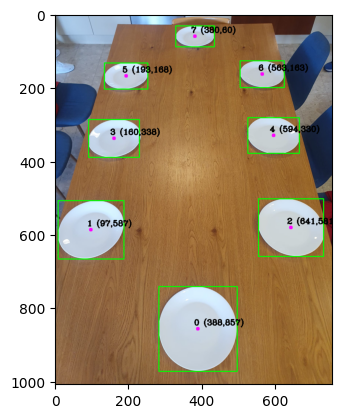

In [4]:
image_path = "Images/table8NoMap.jpg"
conts = detect_plates(image_path,
                      min_area=1000, 
                      scale_by=0.5, 
                      threshold=170, 
                      canny_upper=150, 
                      canny_lower=50, 
                      show=True)

In [5]:
image = cv2.imread(image_path)
image = cv2.resize(image, (0, 0), fx = 0.5, fy = 0.5)

In [6]:
import math
from collections import defaultdict
from Spot import Spot

def create_spots(contours):
    spots = {}
    for i in range(len(contours)):
        spots[i] = Spot(i, contours[i]["center"], contours[i]["bbox"])
    return spots

relations = {}
nearby_score = 1
across_score = 0.5
far_score = -1

spots = create_spots(conts)

In [7]:
# TODO: fix this part!
def build_relations(spots):
    relations = {}
    for spot_index, spot in spots.items():
        distances = []
        for other_index, other in spots.items():
            if spot_index != other_index:
                dist = math.dist(spot.location, other.location)
                distances.append((other_index, round(dist, 3)))
        distances.sort(key = lambda x: x[1])
        nearest_spot_1 = spots[distances[0][0]]
        nearest_spot_2 = spots[distances[1][0]]
        relations[spot_index] = [(nearest_spot_1, nearby_score), (nearest_spot_2, nearby_score)]

        for other_index, _ in distances[2:]:
            other = spots[other_index]
            if spot.is_across(other):
                relations[spot_index].append((other, across_score))
            else: 
                relations[spot_index].append((other, far_score))
    return relations

In [8]:
relations = build_relations(spots)

In [9]:
relations

{0: [(Spot #2 at [641, 581]. no one sits here., 1),
  (Spot #1 at [97, 587]. no one sits here., 1),
  (Spot #4 at [594, 330]. no one sits here., -1),
  (Spot #3 at [160, 338]. no one sits here., -1),
  (Spot #6 at [563, 163]. no one sits here., -1),
  (Spot #5 at [193, 168]. no one sits here., -1),
  (Spot #7 at [380, 60]. no one sits here., -1)],
 1: [(Spot #3 at [160, 338]. no one sits here., 1),
  (Spot #0 at [388, 857]. no one sits here., 1),
  (Spot #5 at [193, 168]. no one sits here., -1),
  (Spot #2 at [641, 581]. no one sits here., 0.5),
  (Spot #4 at [594, 330]. no one sits here., -1),
  (Spot #7 at [380, 60]. no one sits here., -1),
  (Spot #6 at [563, 163]. no one sits here., -1)],
 2: [(Spot #4 at [594, 330]. no one sits here., 1),
  (Spot #0 at [388, 857]. no one sits here., 1),
  (Spot #6 at [563, 163]. no one sits here., -1),
  (Spot #3 at [160, 338]. no one sits here., -1),
  (Spot #1 at [97, 587]. no one sits here., 0.5),
  (Spot #7 at [380, 60]. no one sits here., -1)

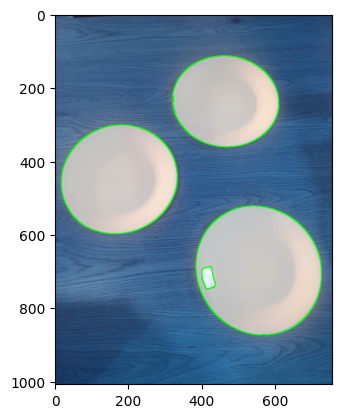

In [81]:
th3 = cv2.adaptiveThreshold(gray,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,11,2)
_, thresh4 = cv2.threshold(gray,180,255,cv2.THRESH_TOZERO)
_, T1 = cv2.threshold(gray,180,255,cv2.THRESH_BINARY)
can = cv2.Canny(thresh4, 150, 50)
contours,hierarchy = cv2.findContours(can,cv2.RETR_LIST,cv2.CHAIN_APPROX_NONE)
img_cont = image.copy()
cv2.drawContours(img_cont, contours, -1, (0, 255, 0), 2)

plt.figure()
plt.imshow(img_cont, cmap='gray', aspect='equal')

8
8
8
8
8
8


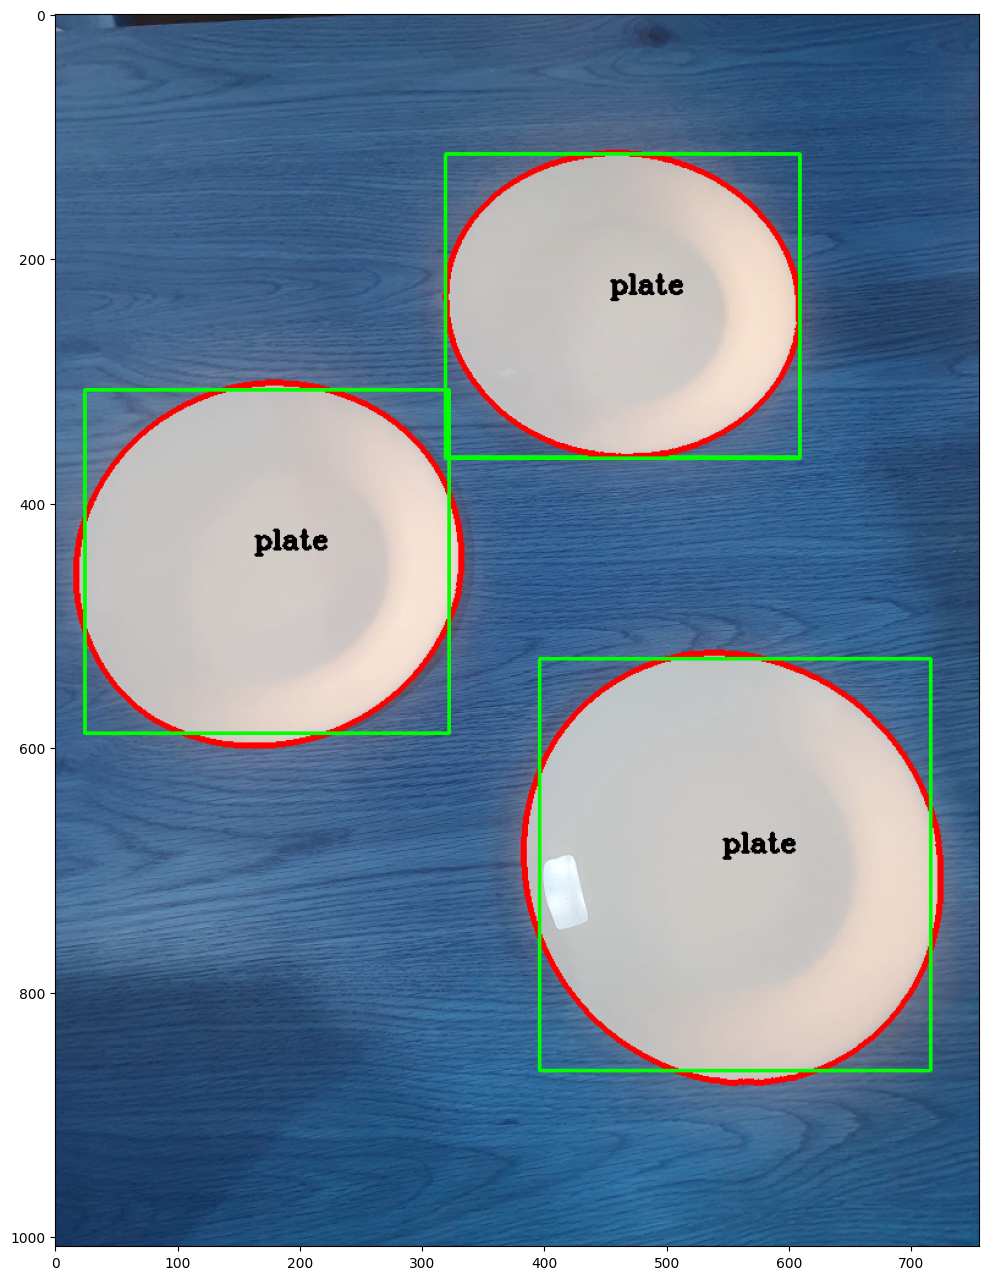

In [82]:
getContours(can, image.copy(), 2000)

In [72]:
def getContours(image, orig, min_area=1000):
    contours,hierarchy = cv2.findContours(image,cv2.RETR_LIST,cv2.CHAIN_APPROX_NONE)
    for cnt in contours:
        area = cv2.contourArea(cnt)
        # print(area)
        if area > min_area:
            cv2.drawContours(orig, cnt, -1, (255, 0, 0), 3)
            peri = cv2.arcLength(cnt,True)
            #print(peri)
            approx = cv2.approxPolyDP(cnt,0.02*peri,True)
            print(len(approx))
            objCor = len(approx)
            x, y, w, h = cv2.boundingRect(approx)
            if objCor > 5: objectType = "plate"
            else: objectType = "None"

            cv2.rectangle(orig,(x,y),(x+w,y+h),(0,255,0),2)
            cv2.putText(orig,objectType,
                        (x+(w//2)-10,y+(h//2)-10),cv2.FONT_HERSHEY_COMPLEX,0.7,
                        (0,0,0),2)
    plt.figure(figsize = (12,16))
    plt.imshow(orig, aspect='equal')

1424.0
6
1457.5
7
0.0
2.0
12.5
91665.0
8
91942.0
8
2.0
4.0
7.5
33.5
5.5
30.5
58.0
25.0
7.5
12.5
14.5
19.5
247.5
13
47312.0
8
47510.0
8


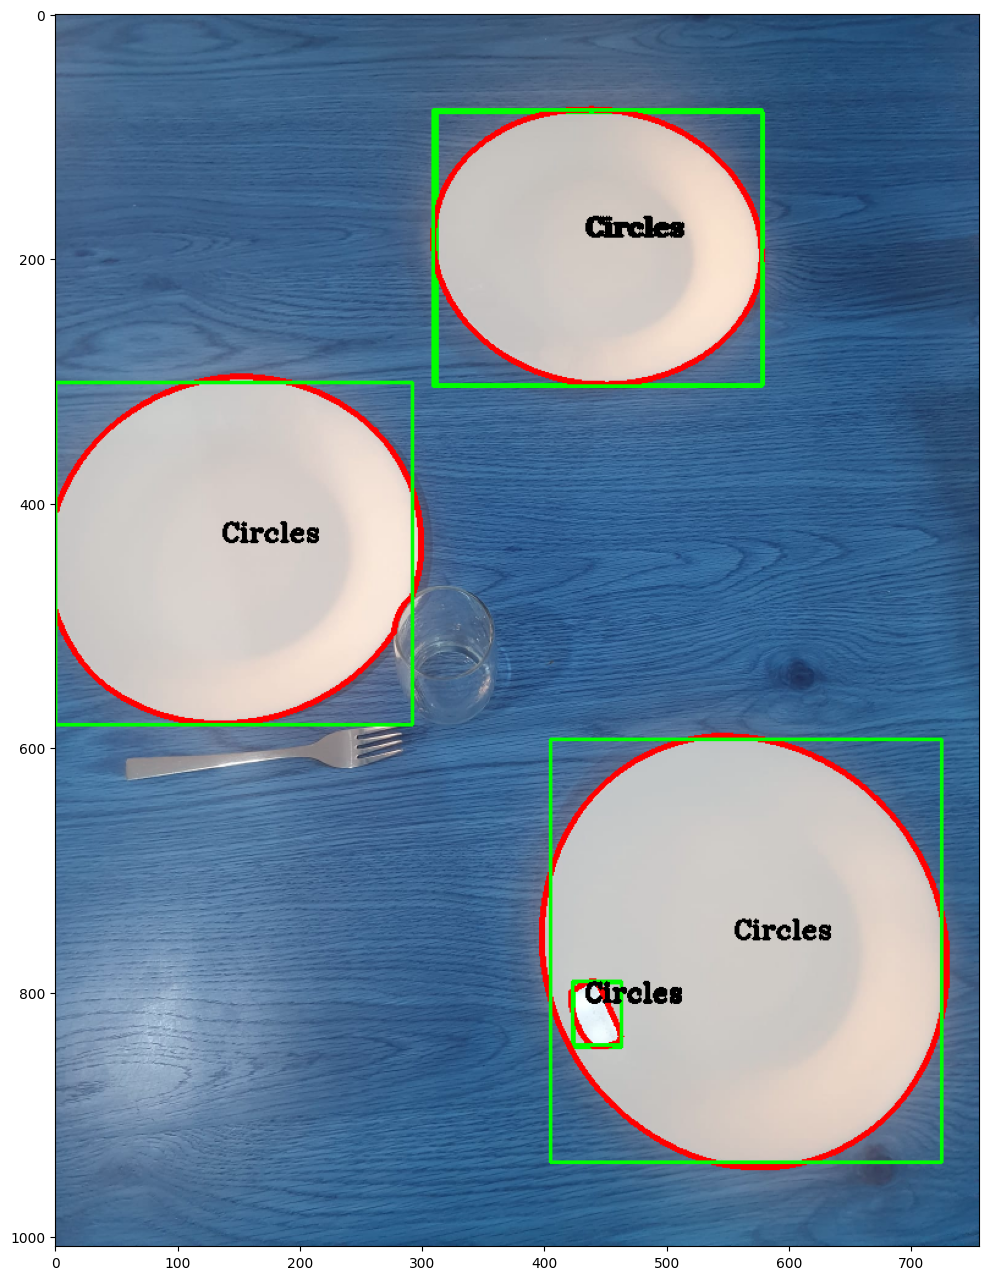

In [30]:
getContours(imgCannyBlur, image.copy())

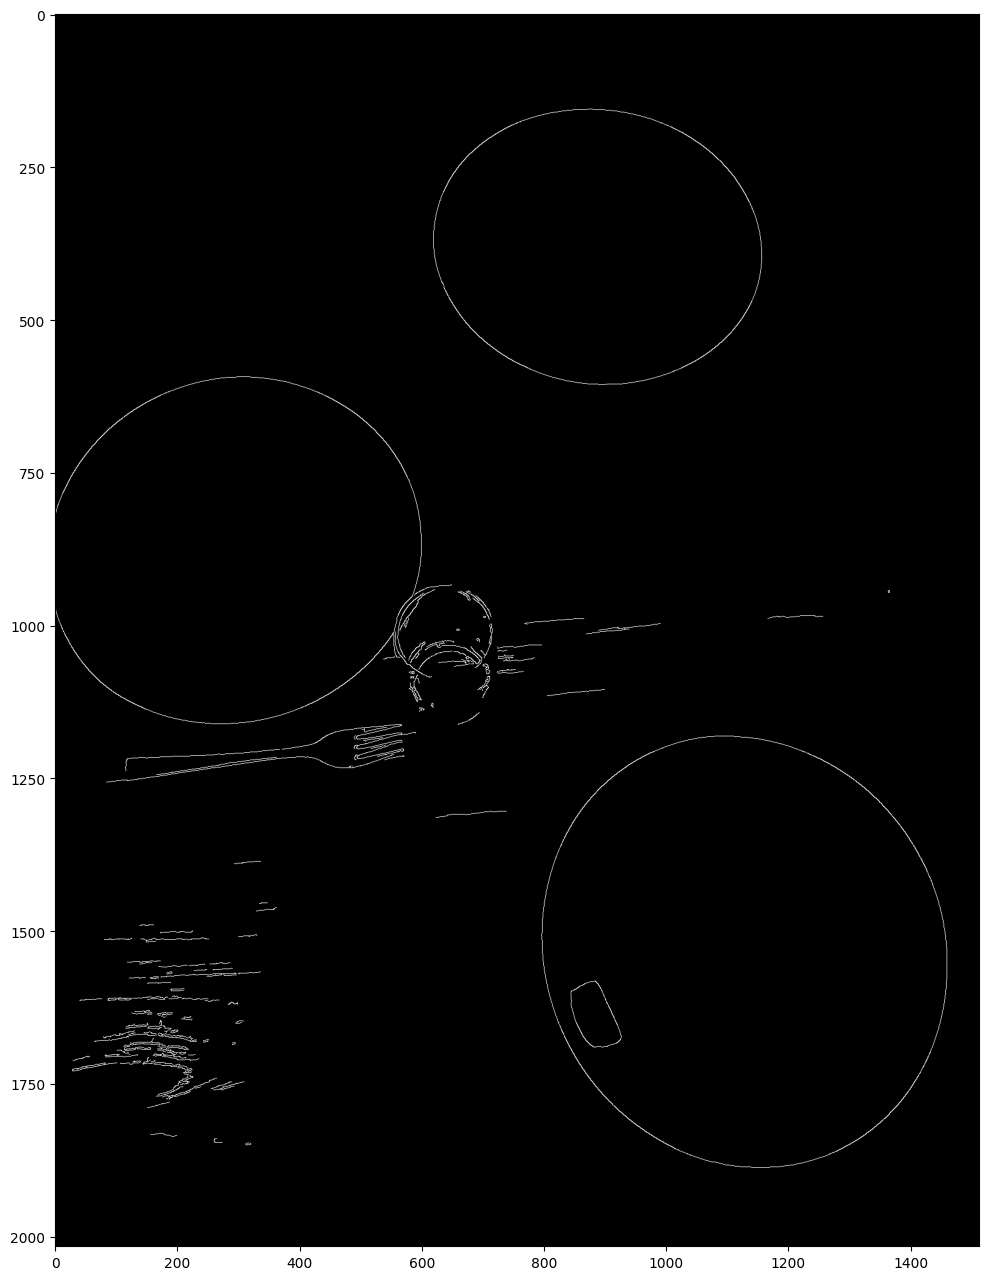

In [17]:
plt.figure(figsize = (12,16))
plt.imshow(imgCannyBlur, cmap='gray', aspect='equal')

In [ ]:
thresholded = cv2.adaptiveThreshold(blur, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 11, 2)

In [32]:
contours, heirarchy = cv2.findContours(imgCannyBlur, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

In [33]:
img_cont = image.copy()
cv2.drawContours(img_cont, contours, -1, (0, 255, 0), 2)
cv2.imshow("Image", img_cont)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [18]:
def on_trackbar_change(v):
    _, threshold = cv2.threshold(gray, 151, 255, cv2.THRESH_BINARY) 
    canny = cv2.Canny(threshold,v,T2)
    
    contours, heirarchy = cv2.findContours(canny, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    img_cont = image.copy()
    cv2.drawContours(img_cont, contours, -1, (0, 255, 0), 2)
    cv2.imshow(title_window, img_cont)

def empty(val):
    pass


def on_thresh_change(v):
    _, threshold = cv2.threshold(gray, v, 255, cv2.THRESH_BINARY) 
    cv2.imshow(title_window, threshold)


T1, T2 = 100, 100
thresh = 130

title_window = "dinnerTable"
cv2.namedWindow(title_window)
cv2.createTrackbar("canny T1", title_window , 100, 500, on_trackbar_change)
# cv2.createTrackbar("canny T2", title_window , 100, 500, empty)
cv2.createTrackbar("threshold", title_window , 0, 255, on_thresh_change)


on_trackbar_change(T1)
cv2.waitKey(0)



-1

In [5]:
_, threshold = cv2.threshold(gray, 170, 255, cv2.THRESH_BINARY) 
cv2.imshow(title_window, threshold)

: 

In [5]:
# gemini suggested code
import cv2

def detect_plates(image):
  # Convert image to grayscale for better color processing
  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

  # Apply adaptive thresholding to handle uneven lighting
  thresh = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_MEAN_C, 
                                 cv2.THRESH_BINARY_INV, 11, 2)

  # Find contours in the thresholded image
  contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

  # Initialize variables
  plates = []

  # Loop through contours
  for cnt in contours:
    # Get contour area and approximate polygon
    area = cv2.contourArea(cnt)
    approx = cv2.approxPolyDP(cnt, 0.01 * cv2.arcLength(cnt, True), True)

    # Check if contour has 4 sides (rectangular) and minimum area
    if len(approx) == 4 and area > 1000:
      # Get bounding rectangle of the plate
      x, y, w, h = cv2.boundingRect(cnt)
      plates.append((x, y, w, h))
      # You can optionally draw the rectangle on the image here
      # cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)

  return len(plates), plates

# Example usage
image = cv2.imread("Images/table17verticalCropped.jpg")
num_plates, contours = detect_plates(image)

print(f"Number of plates detected: {num_plates}")

# Display the image with optional rectangle overlays (commented out)
# cv2.imshow("Plates", image)
# cv2.waitKey(0)
# cv2.destroyAllWindows()


Number of plates detected: 3


In [9]:
from ultralytics import YOLO

# Load a model
model = YOLO('yolov8n.pt')  # pretrained YOLOv8n model

# Run batched inference on a list of images
results = model(['Images/3platesToo.jpeg', 'Images/plateAndFork.jpeg'])  # return a list of Results objects


0: 640x640 1 dining table, 3 mouses, 49.5ms
1: 640x640 1 fork, 1 dining table, 49.5ms
Speed: 0.0ms preprocess, 49.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


In [10]:
for result in results:
    boxes = result.boxes  # Boxes object for bounding box outputs
    masks = result.masks  # Masks object for segmentation masks outputs
    keypoints = result.keypoints  # Keypoints object for pose outputs
    probs = result.probs  # Probs object for classification outputs
    result.show()  # display to screen
    # result.save(filename='result.jpg')  # save to disk

In [ ]:
results = model(['Images/tableFor3.jpeg']) 
for result in results:
    result.show()


In [3]:
# code from money counter

import cv2
import numpy as np
import matplotlib.pyplot as plt
import cvzone
from cvzone.ColorModule import ColorFinder

def empty(v):
    pass

cv2.namedWindow("Settings")
cv2.resizeWindow("Settings", 640, 240)
cv2.createTrackbar("T1", "Settings", 219, 255, empty)
cv2.createTrackbar("T2", "Settings", 233, 255, empty)
# cv2.createTrackbar("Threshold", "Settings", 180, 255, empty)



def preProcessing(img):
    T1 = cv2.getTrackbarPos("T1", "Settings")
    T2 = cv2.getTrackbarPos("T2", "Settings")
    # threshold = cv2.getTrackbarPos("Threshold", "Settings")
    # _, thresh = cv2.threshold(img, threshold, 255, cv2.THRESH_TOZERO)
    # imgPre = cv2.Canny(thresh, T1, T2)
    imgPre = cv2.Canny(img, T1, T2)
    kernel = np.ones((3, 3), np.uint8)
    imgPre = cv2.dilate(imgPre, kernel, iterations=1)
    imgPre = cv2.morphologyEx(imgPre, cv2.MORPH_CLOSE, kernel)

    return imgPre

scale_by = 0.5

img = cv2.imread("Images/3platesToo.jpeg")
img = cv2.resize(img, (480, 640))
orig = img.copy()
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
imgPre = cv2.GaussianBlur(gray, (5, 5), 3)

while True:
    imgPre = preProcessing(imgPre)
    imgContours, conFound = cvzone.findContours(img, imgPre, minArea=20)

    if conFound:
        for count, contour in enumerate(conFound):
            peri = cv2.arcLength(contour['cnt'], True)
            approx = cv2.approxPolyDP(contour['cnt'], 0.02 * peri, True)

            if len(approx) > 5:
                area = contour['area']
                x, y, width, height = contour['bbox']
                imgCrop = img[y:y + height, x:x + width]
                
                

    imgStacked = cvzone.stackImages([img, imgPre, imgContours], 2, 1)

    cv2.imshow("Image", imgStacked)
    cv2.waitKey(1)
    cv2.destroyAllWindows()

error: OpenCV(4.9.0) D:\a\opencv-python\opencv-python\opencv\modules\highgui\src\window_w32.cpp:2561: error: (-27:Null pointer) NULL window: 'Settings' in function 'cvGetTrackbarPos'


In [20]:
import random

people = {0 : "uri",
          1 : "mom",
          2 : "michal",
          3 : "clair",
          4 : "daniel",
          5 : "nuriel",
          6 : "ben",
          7 : "dad"
          }

person_matrix = np.zeros((len(people), len(people)))
for i in range(len(people)):
    for j in range(i + 1):
        if i == j:
            person_matrix[i][j] = 0.5  # Diagonal elements
        else:
            person_matrix[i][j] = person_matrix[j][i] = np.random.choice([0.0, 0.5, 1.0], 1, p=[0.25,0.5,0.25])[0]

person_matrix

array([[0.5, 0.5, 0.5, 0.5, 0. , 0.5, 0.5, 0.5],
       [0.5, 0.5, 1. , 0.5, 1. , 0.5, 0. , 0. ],
       [0.5, 1. , 0.5, 0. , 0. , 0.5, 0.5, 0. ],
       [0.5, 0.5, 0. , 0.5, 1. , 0.5, 0.5, 1. ],
       [0. , 1. , 0. , 1. , 0.5, 0.5, 0.5, 0.5],
       [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0. , 0.5],
       [0.5, 0. , 0.5, 0.5, 0.5, 0. , 0.5, 0.5],
       [0.5, 0. , 0. , 1. , 0.5, 0.5, 0.5, 0.5]])

In [21]:
want = set()
dont_want = set()
for i in range(len(people)):
    for j in range(i + 1):
        if person_matrix[i][j] == 1:
            want.add((people[i], people[j]))
        elif person_matrix[i][j] == 0:
            dont_want.add((people[i], people[j]))

print(want)
print(dont_want)

{('dad', 'clair'), ('daniel', 'clair'), ('michal', 'mom'), ('daniel', 'mom')}
{('dad', 'michal'), ('daniel', 'michal'), ('daniel', 'uri'), ('dad', 'mom'), ('ben', 'nuriel'), ('clair', 'michal'), ('ben', 'mom')}


In [17]:
from actions.relaxtionLabel.relaxtion import findSitting



1.0